# Support Vector Machine(SVM) to classify images of cats and dogs

In [29]:
import os, zipfile, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# paths

In [30]:
ZIP_PATH = r"C:\Users\ANKITA DAS\Documents\Codes\ML\skillcraft\SCT_ML_3\train.zip"
EXTRACT_DIR = r"C:\Users\ANKITA DAS\Documents\Codes\ML\skillcraft\SCT_ML_3\train"
IMG_SIZE     = 160          
N_SAMPLES    = 500  

# Extracting dataset 

In [31]:
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Extraction done.")
else:
    print("Train folder already exists.")

Train folder already exists.


#  Detecting all image files

In [32]:
image_files = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, f))
print(f"Total images found: {len(image_files)}")
cat_files = [f for f in image_files if "cat" in os.path.basename(f).lower()]
dog_files = [f for f in image_files if "dog" in os.path.basename(f).lower()]
print(f"Found {len(cat_files)} cat images, {len(dog_files)} dog images")
if N_SAMPLES:
    cat_files = random.sample(cat_files, min(len(cat_files), N_SAMPLES))
    dog_files = random.sample(dog_files, min(len(dog_files), N_SAMPLES))
print(f"Using {len(cat_files)} cats, {len(dog_files)} dogs")

Total images found: 25000
Found 12500 cat images, 12500 dog images
Using 500 cats, 500 dogs


# Separating cat and dog images

#  Loading images and labels

In [33]:
X, y, raw = [], [], []
for path in cat_files:
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = img_to_array(img)
    raw.append(arr.astype("uint8"))         
    X.append(preprocess_input(arr))
    y.append(0)
for path in dog_files:
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = img_to_array(img)
    raw.append(arr.astype("uint8"))
    X.append(preprocess_input(arr))
    y.append(1)
X = np.array(X, dtype="float32")
y = np.array(y)
raw = np.array(raw, dtype="uint8")
print("Dataset loaded:", X.shape, y.shape)

Dataset loaded: (1000, 160, 160, 3) (1000,)


# Data Visualization

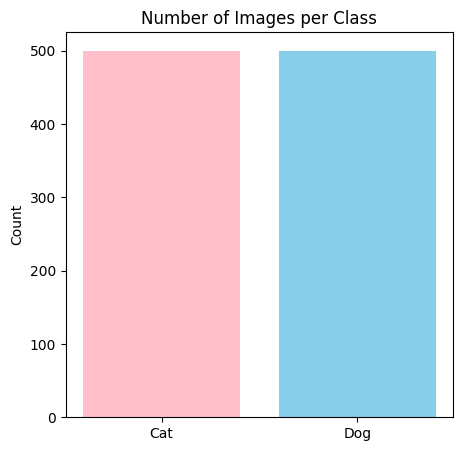

In [35]:
labels_count = [np.sum(y == 0), np.sum(y == 1)]
class_names = ['Cat', 'Dog']
plt.figure(figsize=(5, 5))
plt.bar(class_names, labels_count, color=['pink', 'skyblue'])
plt.title('Number of Images per Class')
plt.ylabel('Count')
plt.show()

# Sample images

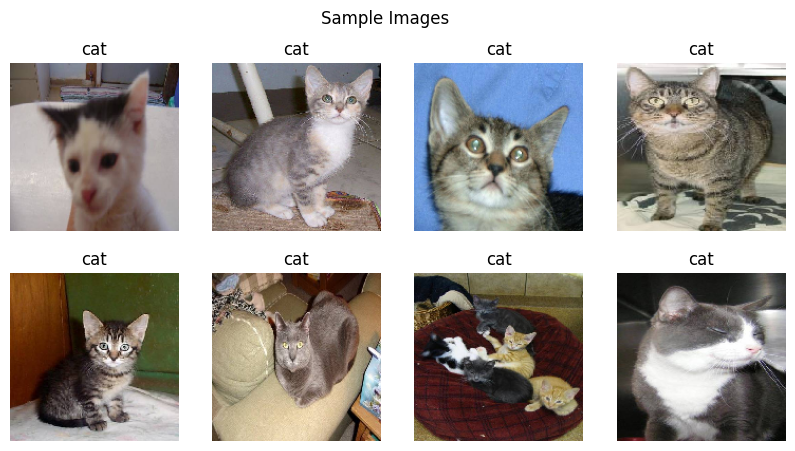

In [36]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(raw[i].astype("uint8"))
    plt.title("cat" if y[i] == 0 else "dog")
    plt.axis("off")
plt.suptitle("Sample Images")
plt.show()

# Feature Extraction

In [37]:
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
features = base_model.predict(X, batch_size=32, verbose=1)
print("Features shape:", features.shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 738ms/step
Features shape: (1000, 1280)


# Train-Test Split

In [38]:
X_train, X_test, y_train, y_test, raw_train, raw_test = train_test_split(
    features, y, raw, test_size=0.2, random_state=42, stratify=y
)

# Training the SVM model

In [39]:
svm = SVC(kernel="linear", probability=False, random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

# Evaluating the model

In [41]:
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%\n")

Test Accuracy: 96.50%



# Confusion Matrix

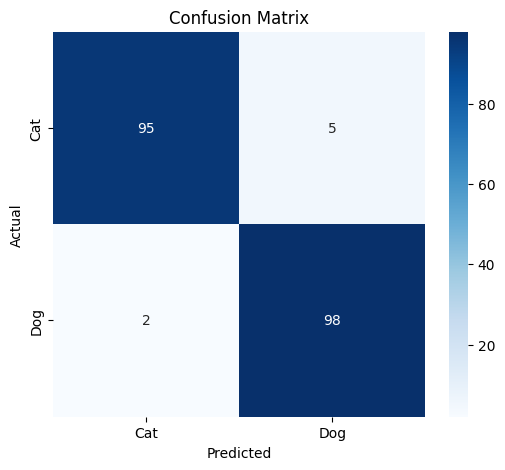

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report

In [43]:
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         Cat       0.98      0.95      0.96       100
         Dog       0.95      0.98      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



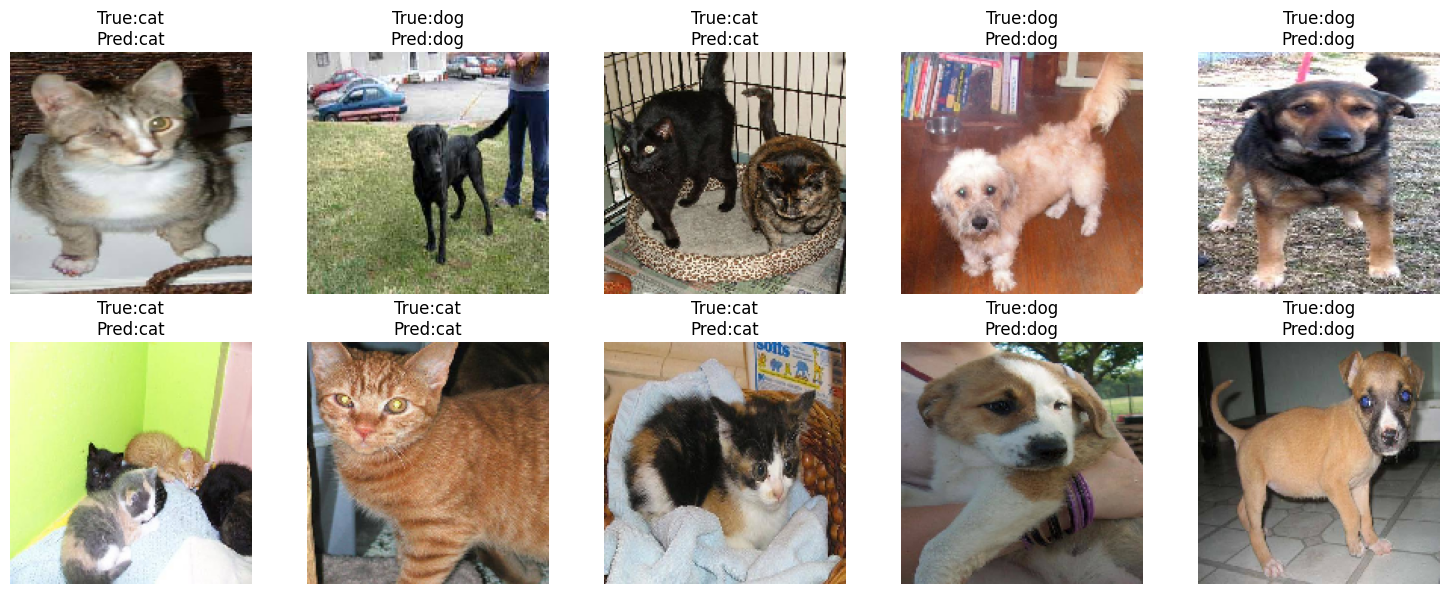

In [45]:
indices = np.random.choice(len(X_test), size=10, replace=False)
plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(raw_test[idx].astype("uint8"))
    plt.title(f"True:{'cat' if y_test[idx]==0 else 'dog'}\nPred:{'cat' if y_pred[idx]==0 else 'dog'}")
    plt.axis("off")
plt.tight_layout()
plt.show()